# Masking the Data
Placing a limit on the frequency may help you achieve an optimal result in the fitting process.

Even on a good dataset, we can get a sizable error if we take into consideration every single frequency of data. This is because there can be some data that is considered an outlier. Take for example, 'DE_40_1_30.mpt' which by all accounts, is a good dataset without any unusual spikes or drops in the data. Let's take a look at if we were to import all frequencies in the file.

In [256]:
#Locate the data, prepare for import of the MPT file
#Import necessary packaging
from utils.tools import *
path=r"C:\Users\cjang\Desktop\impedance_data\data\\"
data = ['DE_40_4_60.mpt']
ex_mpt = mpt_data(path,data)

No handles with labels found to put in legend.


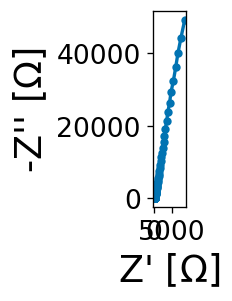

In [257]:
ex_mpt.mpt_plot()

If we take the guessing iterator and run it on this dataset, the guessing iterator has to find a fitting equation that satisfies every single point on this set, or something that is close.

Because the iterator cut out at 1000 iterations and return the set of coefficients at that state, we cannot say with full confidence that this is the best fit because it didn't necessarily satisfy the threshold. If we graph this 'optimal' set of coefficients, we aren't guaranteed a great fitting graph...

What we can do is eliminate some of the frequencies from the file to make it easier to get a more accurate graph. But how do we determine which frequencies to drop from the file? 

# Linear Kramer Kronig Analysis

The Linear Kramer Kronig Analysis determines the causality, linearity, and stability of the dataset. It'll help you determine a mask by examining the residual graph. Running the function ex_mpt.LinKK() will allow you to see where your residuals are fluctuating the most. From here you can determine on your own what your boundaries should be.

cycle || No. RC-elements ||   u
[1]            7            0.83


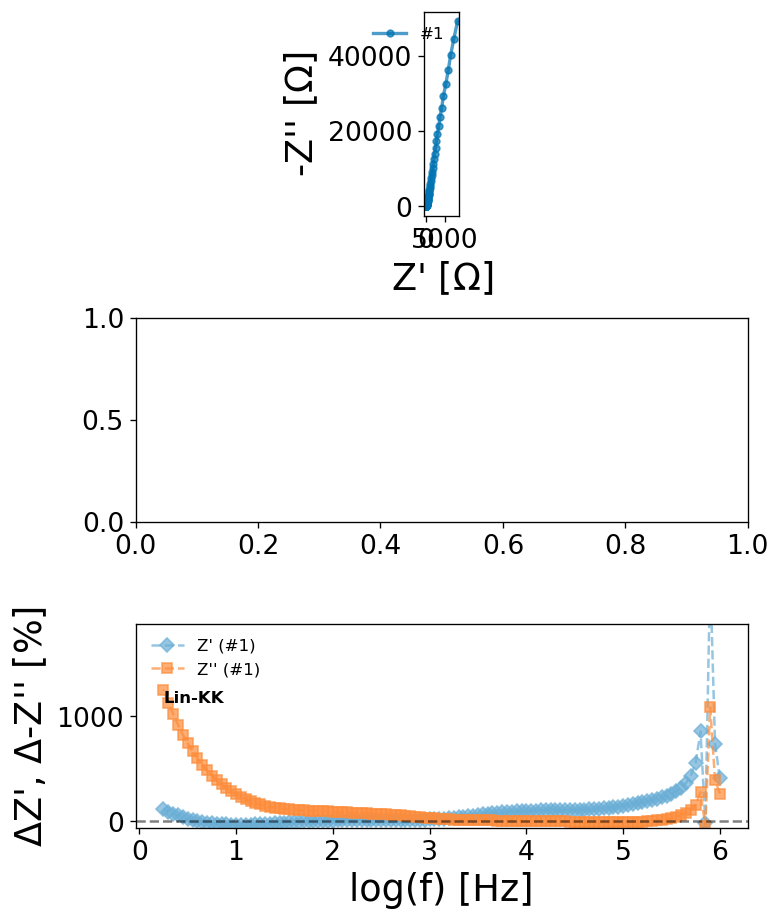

In [258]:
#Will be updated
ex_mpt.Lin_KK(plot = 'w_data')

cycle || No. RC-elements ||   u
[1]            7            0.83


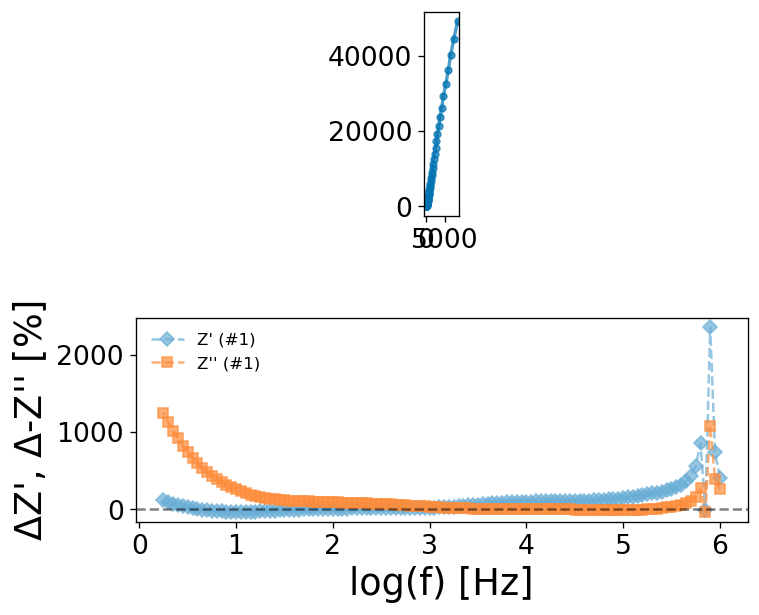

In [259]:
num_RC='auto' 
legend='on'
plot='residuals'
bode='off'
nyq_xlim='none'
nyq_ylim='none'
weight_func='Boukamp'



print('cycle || No. RC-elements ||   u')
ex_mpt.decade = []
ex_mpt.Rparam = []
ex_mpt.t_const = []
ex_mpt.Lin_KK_Fit = []
ex_mpt.R_names = []
ex_mpt.KK_R0 = []
ex_mpt.KK_R = []
ex_mpt.number_RC = []
ex_mpt.number_RC_sort = []

ex_mpt.KK_u = []
ex_mpt.KK_Rgreater = []
ex_mpt.KK_Rminor = []
M = 2
for i in range(len(ex_mpt.df)):
    ex_mpt.decade.append(np.log10(np.max(ex_mpt.df[i].f))-np.log10(np.min(ex_mpt.df[i].f))) #determine the number of RC circuits based on the number of decades measured and num_RC
    ex_mpt.number_RC.append(M)
    ex_mpt.number_RC_sort.append(M) #needed for ex_mpt.KK_R
    ex_mpt.Rparam.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0]) #Creates intial guesses for R's
    ex_mpt.t_const.append(KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i]))) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits

    ex_mpt.Lin_KK_Fit.append(minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) )) #maxfev=99
    ex_mpt.R_names.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1]) #creates R names
    for j in range(len(ex_mpt.R_names[i])):
        ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[i].params.get(ex_mpt.R_names[i][j]).value)
ex_mpt.number_RC_sort.insert(0,0) #needed for ex_mpt.KK_R
for i in range(len(ex_mpt.df)):
    ex_mpt.KK_R.append(ex_mpt.KK_R0[int(np.cumsum(ex_mpt.number_RC_sort)[i]):int(np.cumsum(ex_mpt.number_RC_sort)[i+1])]) #assigns resistances from each spectra to their respective df
    ex_mpt.KK_Rgreater.append(np.where(np.array(ex_mpt.KK_R)[i] >= 0, np.array(ex_mpt.KK_R)[i], 0) )
    ex_mpt.KK_Rminor.append(np.where(np.array(ex_mpt.KK_R)[i] < 0, np.array(ex_mpt.KK_R)[i], 0) )
    ex_mpt.KK_u.append(1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i]))))

for i in range(len(ex_mpt.df)):
    while ex_mpt.KK_u[i] <= 0.75 or ex_mpt.KK_u[i] >= 0.88:
        ex_mpt.number_RC_sort0 = []
        ex_mpt.KK_R_lim = []
        ex_mpt.number_RC[i] = ex_mpt.number_RC[i] + 1
        ex_mpt.number_RC_sort0.append(ex_mpt.number_RC)
        ex_mpt.number_RC_sort = np.insert(ex_mpt.number_RC_sort0, 0,0)
        ex_mpt.Rparam[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0] #Creates intial guesses for R's
        ex_mpt.t_const[i] = KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i])) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits
        ex_mpt.Lin_KK_Fit[i] = minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) ) #maxfev=99
        ex_mpt.R_names[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1] #creates R names
        ex_mpt.KK_R0 = np.delete(np.array(ex_mpt.KK_R0), np.s_[0:len(ex_mpt.KK_R0)])
        ex_mpt.KK_R0 = []
        for q in range(len(ex_mpt.df)):
            for j in range(len(ex_mpt.R_names[q])):
                ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[q].params.get(ex_mpt.R_names[q][j]).value)
        ex_mpt.KK_R_lim = np.cumsum(ex_mpt.number_RC_sort) #used for KK_R[i]

        ex_mpt.KK_R[i] = ex_mpt.KK_R0[ex_mpt.KK_R_lim[i]:ex_mpt.KK_R_lim[i+1]] #assigns resistances from each spectra to their respective df
        ex_mpt.KK_Rgreater[i] = np.where(np.array(ex_mpt.KK_R[i]) >= 0, np.array(ex_mpt.KK_R[i]), 0)
        ex_mpt.KK_Rminor[i] = np.where(np.array(ex_mpt.KK_R[i]) < 0, np.array(ex_mpt.KK_R[i]), 0)
        ex_mpt.KK_u[i] = 1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i])))
    else:
        print('['+str(i+1)+']'+'            '+str(ex_mpt.number_RC[i]),'           '+str(np.round(ex_mpt.KK_u[i],2)))

ex_mpt.KK_circuit_fit = []
ex_mpt.KK_rr_re = []
ex_mpt.KK_rr_im = []
functs = []
for i in range(2,81):
    functs.append('KK_RC'+str(i))

for i in range(len(ex_mpt.df)):
    cir_num = int(ex_mpt.number_RC[i])
    cir_funct = eval(functs[cir_num - 2])
    ex_mpt.KK_circuit_fit.append(cir_funct(w=ex_mpt.df[0].w, Rs=ex_mpt.Lin_KK_Fit[0].params.get('Rs').value, R_values=ex_mpt.KK_R[0], t_values=ex_mpt.t_const[0]))
    if cir_num >= 81:
        print('RC simulation circuit not defined')
        print('   Number of RC = ', ex_mpt.number_RC)
    ex_mpt.KK_rr_re.append(residual_real(re=ex_mpt.df[i].re, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the real part
    ex_mpt.KK_rr_im.append(residual_imag(im=ex_mpt.df[i].im, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the imag part
    
    


   
    fig = figure(figsize=(6, 8), dpi=120, facecolor='w', edgecolor='k')
    fig.subplots_adjust(left=0.1, right=0.95, hspace=0.5, bottom=0.1, top=0.95)
    ax = fig.add_subplot(311, aspect='equal')
    ax1 = fig.add_subplot(312)

    colors = sns.color_palette("colorblind", n_colors=len(ex_mpt.df))
    colors_real = sns.color_palette("Blues", n_colors=len(ex_mpt.df)+2)
    colors_imag = sns.color_palette("Oranges", n_colors=len(ex_mpt.df)+2)

    ### Nyquist Plot
    for i in range(len(ex_mpt.df)):
        ax.plot(ex_mpt.df[i].re, ex_mpt.df[i].im, marker='o', ms=4, lw=2, color=colors[i], ls='-', alpha=.7, label=ex_mpt.label_cycleno[i])


    ### Kramers-Kronig Relative Residuals    
    for i in range(len(ex_mpt.df)):
        ax1.plot(np.log10(ex_mpt.df[i].f), ex_mpt.KK_rr_re[i]*100, color=colors_real[i+1], marker='D', ls='--', ms=6, alpha=.7, label=ex_mpt.label_re_1[i])
        ax1.plot(np.log10(ex_mpt.df[i].f), ex_mpt.KK_rr_im[i]*100, color=colors_imag[i+1], marker='s', ls='--', ms=6, alpha=.7, label=ex_mpt.label_im_1[i])
        ax1.set_xlabel("log(f) [Hz]")
        ax1.set_ylabel("$\Delta$Z', $\Delta$-Z'' [%]")
        if legend == 'on' or legend == 'potential': 
            ax1.legend(loc='best', fontsize=10, frameon=False)        
    ax1.axhline(0, ls='--', c='k', alpha=.5)








kk_df = pd.DataFrame({'f':np.log10(ex_mpt.df_raw.f), 're':ex_mpt.KK_rr_re[0]*100, 'im':ex_mpt.KK_rr_im[0]*100})

In [260]:
re_avg, im_avg  = mean(ex_mpt.KK_rr_re)*100, mean(ex_mpt.KK_rr_im)*100
re_avg, im_avg 

(104.3210191594898, 144.57391052004732)

In [261]:
z = kk_df[abs(kk_df['re']) <= re_avg * .6]
z = z[z['im'] <= im_avg * .6]
z['f']

3     5.850002
50    3.499826
51    3.449832
52    3.399813
53    3.349831
54    3.300082
55    3.250003
56    3.200168
57    3.149785
58    3.099954
59    3.049913
60    3.000139
61    2.950086
62    2.899951
63    2.849732
64    2.800036
65    2.749998
66    2.700223
67    2.650170
68    2.599980
69    2.549812
70    2.500121
71    2.450086
72    2.399750
73    2.350103
74    2.300058
75    2.249886
76    2.199833
77    2.150177
78    2.099838
Name: f, dtype: float64

In [262]:
#Notice how the graph shows log(f) not f. We must translate back
#so instead of 1.75 and 6, we must insert 10**1.75 and 10**6
masked_mpt = mpt_data(path,data, mask = [10**5.850002,  10** 2.099838])
#masked_mpt.guesser(Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2)

No handles with labels found to put in legend.


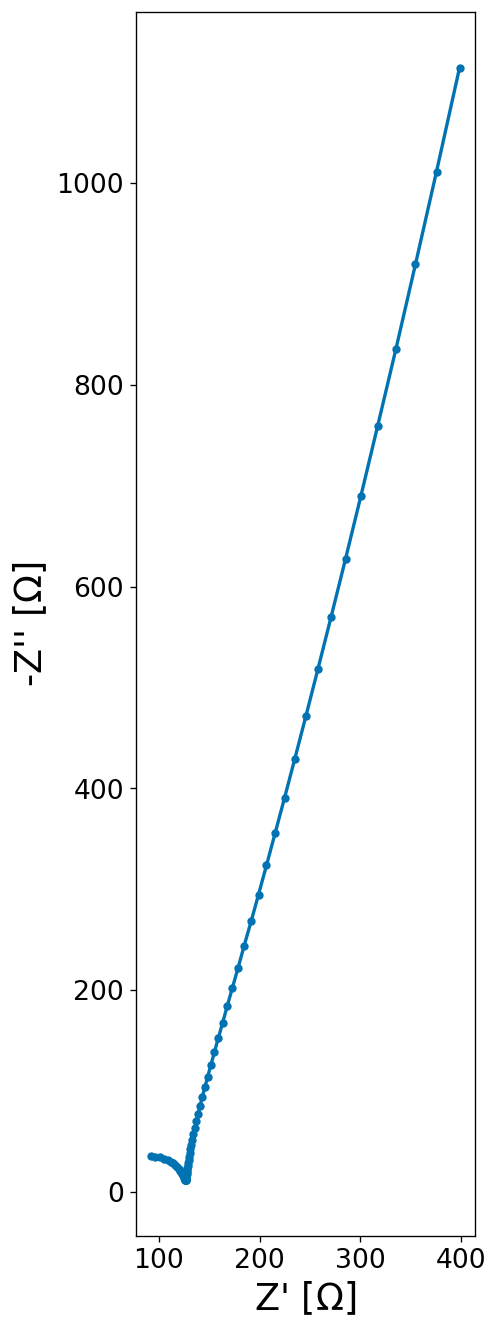

In [263]:
masked_mpt.set_new_gph_dims(30,30)
masked_mpt.mpt_plot()

# Automated Masker

The process above is ideal if all your fitting is a single mpt file. If we want to fit multiple files, or hundreds of files in a batch folder, we need a more automated process. We can call on ex_mpt.masker() to find the best window for us. 

Calling masker takes the average of the distance between the residuals and uses it as an additional threshold, so if the residual lands outside the threshold, all frequencies associated with that residual point will be omitted from the graph. We then run the guessing iterator and see if it achieves 1e-10 error within a thousand iterations. If it does not, we shrink the threshold by a factor of 0.9 to increase exclusivity. 


In [264]:
def leastsq_errorfunc(params, w, re, im, circuit, weight_func):
    if circuit == 'R-RQ-RQ':
        re_fit = cir_RsRQRQ_fit(params, w).real
        im_fit = -cir_RsRQRQ_fit(params, w).imag
    else:
        print('Circuit is not defined in leastsq_errorfunc()')
    
    error = [(re-re_fit)**2, (im-im_fit)**2] #sum of squares
    print('ERROR: ', sum(error))
    #Different Weighing options, see Lasia
    if weight_func == 'modulus':
        weight = [1/((re_fit**2 + im_fit**2)**(1/2)), 1/((re_fit**2 + im_fit**2)**(1/2))]
    elif weight_func == 'proportional':
        weight = [1/(re_fit**2), 1/(im_fit**2)]
    elif weight_func == 'unity':
        unity_1s = []
        for k in range(len(re)):
            unity_1s.append(1) #makes an array of [1]'s, so that the weighing is == 1 * sum of squres.
        weight = [unity_1s, unity_1s]
    else:
        print('weight not defined in leastsq_errorfunc()')
        
    S = np.array(weight) * error #weighted sum of squares
    print('Weighted SUM OF SQUARES: ',sum(S)) 
    return sum(S)

In [265]:
import sys, traceback

def guesser(ex_mpt, Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2):
    
    params = Parameters()
    guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
    #adding to the parameters package to send to the fitting function
    params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=10**6)
    params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=10**6)
    params.add('n', value=guess_package[2], min=.65, max=1)
    params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
    params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=10**6)
    params.add('n2', value=guess_package[5], min=.65, max=1)
    params.add('fs2', value=guess_package[6], min=10**-2, max=10**6)
    ex_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')

    counter = 0

    
    
    
    while ex_mpt.low_error >= 100 and counter <= 1000:
        
        try:
            counter += 1
            print('ITERATION NO. : ', counter)
            Rs_guess = ex_mpt.fit_Rs[0]

            R_guess = ex_mpt.fit_R[0]
            n_guess = ex_mpt.fit_n[0]
            fs_guess = ex_mpt.fit_fs[0]

            R2_guess = ex_mpt.fit_R2[0]
            n2_guess = ex_mpt.fit_n2[0]
            fs2_guess = ex_mpt.fit_fs2[0]

            guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
            #adding to the parameters package to send to the fitting function
            params = Parameters()
            params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=guess_package[0]*100)
            params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=guess_package[1]*10)
            params.add('n', value=guess_package[2], min=.65, max=1)
            params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
            params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=guess_package[4]*10)
            params.add('n2', value=guess_package[5], min=.65, max=1)
            params.add('fs2', value=guess_package[6], min=10**-2, max=10**1)
            ex_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')

       
        except KeyboardInterrupt:
            print "Shutdown requested...exiting"    
        
        
    ex_mpt.mpt_plot(fitting = 'on')

In [266]:
guesser(masked_mpt)

605.3584124573229
1605.35790442208
1605.357900272751
1605.3579009667233
1605.3582364042882
1605.357761390435
1605.3638767992497
1605.3575635275613
1605.3580757851955
1605.3575677487743
1605.3575634671054
1605.3575642934038
1605.3578997298669
1605.3574247171427
1605.363540129463
1605.3572194377257
1605.3577316962976
1605.3572236589491
1605.3572194999906
1605.35722020357
1605.3575556388091
1605.3570806273183
1605.3631960436676
1605.356881669742
1605.357393927722
1605.3568858909566
1605.3568816056209
1605.3568824355848
1605.3572178696272
1605.3567428593287
1605.3628582799615
1605.3565894705162
1605.3571017288268
1605.3565936917407
1605.3565895365628
1605.3565902363623
1605.3569256692354
1605.3564506600787
1605.3625660854082
1605.356250338113
1605.3567625961791
1605.3562545593315
1605.3562502701043
1605.3562511039609
1605.3565865356209
1605.3561115277078
1605.362226957192
1605.3559326090435
1605.3564448678537
1605.3559368302726
1605.3559326790921
1605.3559333748851
1605.3562688053535
1605.

No handles with labels found to put in legend.


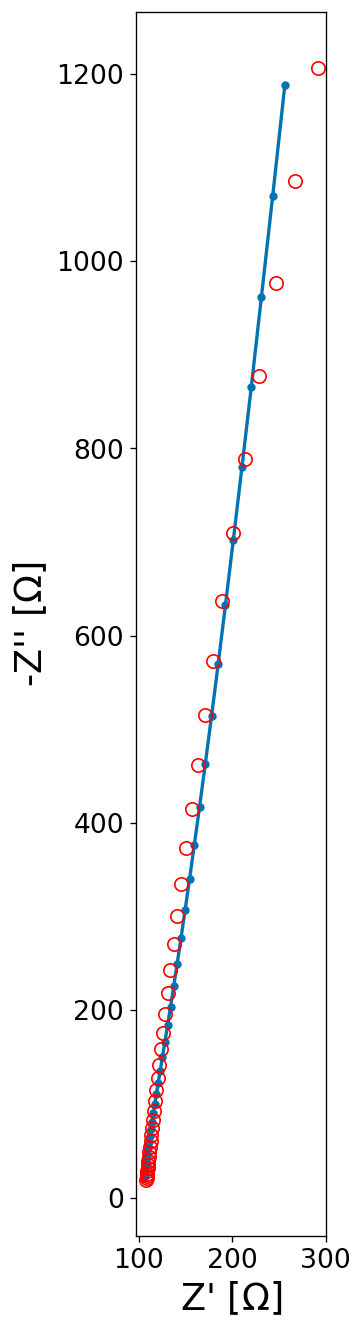

In [253]:
masked_mpt.set_new_gph_dims(30,30)
masked_mpt.mpt_plot(fitting = 'on')

In [231]:
[masked_mpt.fit_Rs[0],masked_mpt.fit_R[0],masked_mpt.fit_n[0],masked_mpt.fit_Q[0],masked_mpt.fit_R2[0],masked_mpt.fit_n2[0],masked_mpt.fit_Q2[0]]

[64.89949030530161,
 28985.45924766047,
 1.0,
 1.736360692910733e-06,
 0.010059005519239614,
 0.9999999425603163,
 1.582213874311975]

Note that there are varying amounts of iteration for convergence, you may take longer to achieve threshold

In [202]:
[ex_mpt.fit_Rs[0],ex_mpt.fit_R[0],ex_mpt.fit_n[0],ex_mpt.fit_Q[0],ex_mpt.fit_R2[0],ex_mpt.fit_n2[0],ex_mpt.fit_Q2[0]]

[4.604418649533515e-06,
 1145.4736079280897,
 0.7440566293164206,
 8.45962954059033e-08,
 536161.0395087485,
 0.7980132591231625,
 6.850675225230497e-08]